In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Goals

# Takeaways

# Plan

# Acquire

- read in master .csv file of original 8 .csv files.

- read in 225 rows and 9 columns.

- read in file with 'Date' column as DatetimeIndex.

In [2]:
df = pd.read_csv('fitbit_master.csv', index_col='Date', parse_dates=True)

In [3]:
df.shape

(225, 9)

# Prepare

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
Calories Burned           225 non-null int64
Steps                     225 non-null int64
Distance                  225 non-null float64
Floors                    225 non-null int64
Minutes Sedentary         225 non-null int64
Minutes Lightly Active    225 non-null int64
Minutes Fairly Active     225 non-null int64
Minutes Very Active       225 non-null int64
Activity Calories         225 non-null int64
dtypes: float64(1), int64(8)
memory usage: 17.6 KB


## Resample by Day by Sum

In [5]:
df = df.resample('D').sum()

## Check Latest Date

- 2018-12-06

- projection will be two weeks out from this date

In [6]:
df.index.max()

Timestamp('2018-12-06 00:00:00')

In [7]:
df.index.min()

Timestamp('2018-04-26 00:00:00')

## Rename Columns

In [8]:
df.columns

Index(['Calories Burned', 'Steps', 'Distance', 'Floors', 'Minutes Sedentary',
       'Minutes Lightly Active', 'Minutes Fairly Active',
       'Minutes Very Active', 'Activity Calories'],
      dtype='object')

In [9]:
df = df.rename(columns={'Calories Burned': 'calories_burned', 'Steps': 'steps', 'Distance': 'distance', 
                  'Floors': 'floors', 'Minutes Sedentary': 'sedentary_mins', 'Minutes Lightly Active': 'lightly_active_mins',
                  'Minutes Fairly Active': 'fairly_active_mins', 'Minutes Very Active': 'very_active_mins', 
                'Activity Calories': 'activity_calories'})

In [10]:
df.head()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories
Date,,,,,,,,,
2018-04-26,2635,2931,1.4,2,1347,93,0,0,566
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124
2018-04-29,2851,1639,0.8,0,891,122,0,0,602
2018-04-30,2825,1323,0.6,0,880,104,0,0,540


## Add column with total of all activity

In [11]:
df['active_total'] = df.lightly_active_mins + df.fairly_active_mins + df.very_active_mins

## Add column with ratio of active time to sedentary time

In [12]:
df['ratio_act_sed'] = df.active_total/df.sedentary_mins

## Add column with ratio of steps to distance

In [13]:
df['ratio_steps_distance'] = df.steps/df.distance

## Add column with ratio of calories to steps

In [14]:
df['ratio_cal_steps'] = df.calories_burned/df.steps

## Add column with ratio of active time to calories

In [15]:
df['ratio_active_cal'] = df.active_total/df.calories_burned

## Add column with ratio of sedentary time to calories

In [16]:
df['ratio_sed_cal'] = df.sedentary_mins/df.calories_burned

## Add a Month Column

In [17]:
df['month'] = df.index.month

## Add a Day of the Week Column

In [18]:
df['weekday'] = df.index.strftime('%w %a')

In [19]:
df.head()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,month,weekday
Date,,,,,,,,,,,,,,,,,
2018-04-26,2635,2931,1.4,2,1347,93,0,0,566,93,0.069042,2093.571429,0.899011,0.035294,0.511195,4,4 Thu
2018-04-27,3649,9971,4.7,19,1158,219,46,17,1752,282,0.243523,2121.489362,0.365961,0.077281,0.317347,4,5 Fri
2018-04-28,3379,3521,1.7,2,702,155,22,11,1124,188,0.267806,2071.176471,0.959671,0.055638,0.207754,4,6 Sat
2018-04-29,2851,1639,0.8,0,891,122,0,0,602,122,0.136925,2048.750000,1.739475,0.042792,0.312522,4,0 Sun
2018-04-30,2825,1323,0.6,0,880,104,0,0,540,104,0.118182,2205.000000,2.135299,0.036814,0.311504,4,1 Mon


# Explore

- Begin stage with 225 rows and 17 columns

- 33 Thursdays, 32 each Friday through Wednesday

    - We will drop the first row which is a Thursday to keep weekday count equal.

In [21]:
df.shape

(225, 17)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Freq: D
Data columns (total 17 columns):
calories_burned         225 non-null int64
steps                   225 non-null int64
distance                225 non-null float64
floors                  225 non-null int64
sedentary_mins          225 non-null int64
lightly_active_mins     225 non-null int64
fairly_active_mins      225 non-null int64
very_active_mins        225 non-null int64
activity_calories       225 non-null int64
active_total            225 non-null int64
ratio_act_sed           225 non-null float64
ratio_steps_distance    213 non-null float64
ratio_cal_steps         225 non-null float64
ratio_active_cal        225 non-null float64
ratio_sed_cal           225 non-null float64
month                   225 non-null int64
weekday                 225 non-null object
dtypes: float64(6), int64(10), object(1)
memory usage: 31.6+ KB


In [23]:
df.describe()

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,month
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,213.000000,225.000000,225.000000,225.000000,225.000000
mean,3401.911111,8536.186667,4.052000,12.591111,809.520000,188.235556,14.920000,33.871111,1484.546667,237.026667,0.340755,inf,inf,0.066193,0.255918,8.008889
std,632.426578,5255.746608,2.507472,25.844174,243.232639,75.170001,15.363535,37.195986,747.795790,103.121761,0.203614,NaN,NaN,0.023508,0.129883,2.144326
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1720.000000,0.189401,0.000000,0.035044,4.000000
25%,3069.000000,4714.000000,2.200000,2.000000,654.000000,158.000000,3.000000,2.000000,1062.000000,187.000000,0.213303,2098.148148,0.308263,0.060267,0.176864,6.000000
50%,3385.000000,7806.000000,3.700000,7.000000,750.000000,203.000000,11.000000,15.000000,1481.000000,253.000000,0.324934,2117.068966,0.429876,0.072244,0.219793,8.000000
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,236.000000,21.000000,63.000000,1962.000000,299.000000,0.446337,2131.538462,0.635178,0.079378,0.282792,10.000000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000,505.000000,1.256219,inf,inf,0.110248,0.671642,12.000000


## Equalize Weekdays

- drop the first row leaving us with 224 rows, 17 columns

In [24]:
# retrieve a weekday count, drop the first Thursday '2018-04-26'

df['weekday'].value_counts()

4 Thu    33
1 Mon    32
5 Fri    32
6 Sat    32
3 Wed    32
2 Tue    32
0 Sun    32
Name: weekday, dtype: int64

In [25]:
# drop the first row, an extra Thursday

df = df[df.index != "2018-04-26"]

## What's going on here?

In [26]:
df['ratio_steps_distance'] = df.ratio_steps_distance.fillna(0)

In [27]:
df = df.replace([np.inf, -np.inf], 0)

In [28]:
df.isnull().sum()

calories_burned         0
steps                   0
distance                0
floors                  0
sedentary_mins          0
lightly_active_mins     0
fairly_active_mins      0
very_active_mins        0
activity_calories       0
active_total            0
ratio_act_sed           0
ratio_steps_distance    0
ratio_cal_steps         0
ratio_active_cal        0
ratio_sed_cal           0
month                   0
weekday                 0
dtype: int64

In [29]:
(df == 0).astype(int).sum().sort_values(ascending = False)

very_active_mins        50
fairly_active_mins      45
floors                  31
ratio_steps_distance    14
distance                14
steps                   12
ratio_cal_steps         12
activity_calories        9
ratio_active_cal         9
ratio_act_sed            9
active_total             9
lightly_active_mins      9
weekday                  0
sedentary_mins           0
month                    0
ratio_sed_cal            0
calories_burned          0
dtype: int64

## Look at Days with 0 Steps

- There are 0 values for steps in the following dates/date ranges

    - 6/6 - 6/7
    - 6/11
    - 6/26 - 6/30
    - 7/3 - 7/6
    
- We will look for trends before and after the breaks to decide how to handle these rows.

In [30]:
df[df['steps'] == 0]

,calories_burned,steps,distance,floors,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,month,weekday
Date,,,,,,,,,,,,,,,,,
2018-06-06,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,3 Wed
2018-06-07,2146,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671016,6,4 Thu
2018-06-11,2146,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671016,6,1 Mon
2018-06-26,2144,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671642,6,2 Tue
2018-06-27,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,3 Wed
2018-06-28,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,4 Thu
2018-06-29,2180,0,0.0,0,1437,3,0,0,39,3,0.002088,0.0,0.0,0.001376,0.659174,6,5 Fri
2018-06-30,2145,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671329,6,6 Sat
2018-07-03,2144,0,0.0,0,1440,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.671642,7,2 Tue


## Calculate Mean Values by Weekdays

In [ ]:
# Means for Mondays

df[df['weekday'] == '1 Mon'].median()

In [ ]:
# Means for Tuesdays

df[df['weekday'] == '2 Tue'].median()

In [ ]:
# Means for Wednesdays

df[df['weekday'] == '3 Wed'].median()

In [ ]:
# Means for Thursdays

df[df['weekday'] == '4 Thu'].median()

In [ ]:
# Means for Wednesdays

df[df['weekday'] == '5 Fri'].median()

In [ ]:
# Means for Wednesdays

df[df['weekday'] == '6 Sat'].median()

## Plots

### Calories Burned by Month

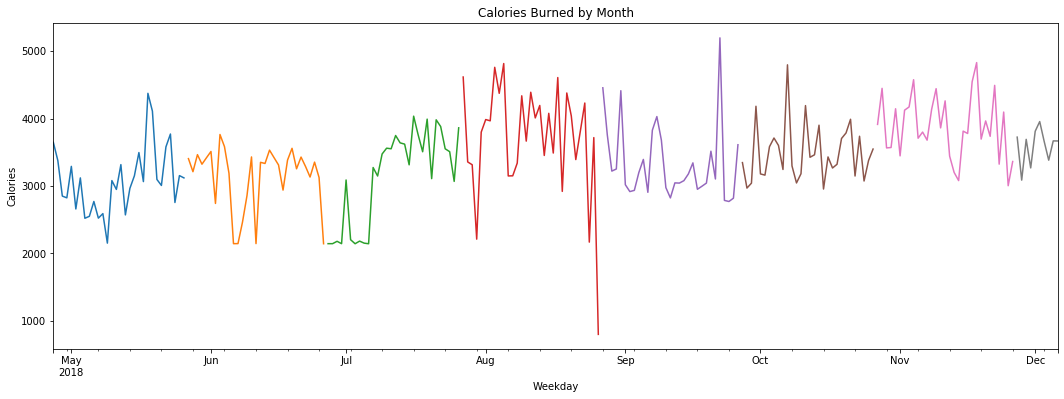

In [31]:
df['calories_burned']['2018-04-27':'2018-05-26'].plot(figsize= (18,6))
df['calories_burned']['2018-05-27':'2018-06-26'].plot()
df['calories_burned']['2018-06-27':'2018-07-26'].plot()
df['calories_burned']['2018-07-27':'2018-08-26'].plot()
df['calories_burned']['2018-08-27':'2018-09-26'].plot()
df['calories_burned']['2018-09-27':'2018-10-26'].plot()
df['calories_burned']['2018-10-27':'2018-11-26'].plot()
df['calories_burned']['2018-11-27':'2018-12-06'].plot()

plt.xlabel('Weekday')
plt.ylabel('Calories')
plt.title('Calories Burned by Month')
plt.show()

### Average Calories Burned by Weekday

- Most calores burned on Saturdays and Sundays

In [32]:
df.groupby(['weekday']).calories_burned.mean()

weekday
0 Sun    3551.46875
1 Mon    3242.75000
2 Tue    3304.09375
3 Wed    3270.46875
4 Thu    3450.65625
5 Fri    3464.71875
6 Sat    3553.18750
Name: calories_burned, dtype: float64

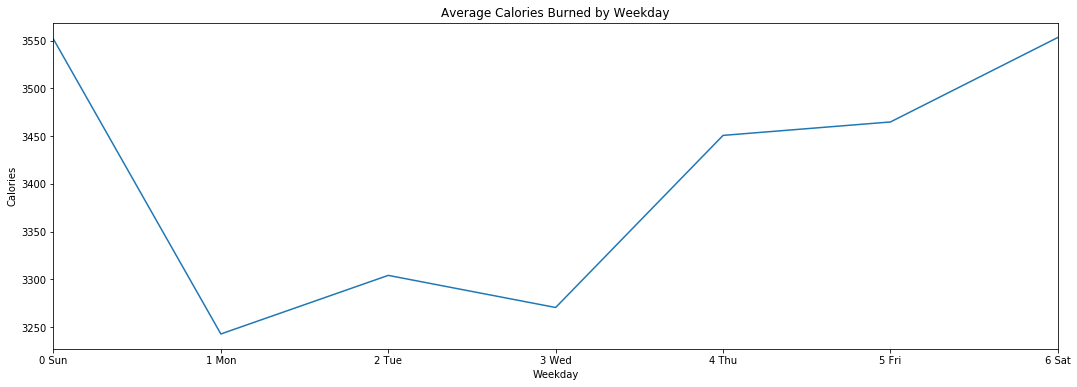

In [33]:
df.groupby(['weekday'])['calories_burned'].mean().plot(figsize = (18,6))

plt.xlabel('Weekday')
plt.ylabel('Calories')
plt.title('Average Calories Burned by Weekday')
plt.show()

### Number of Steps by Day

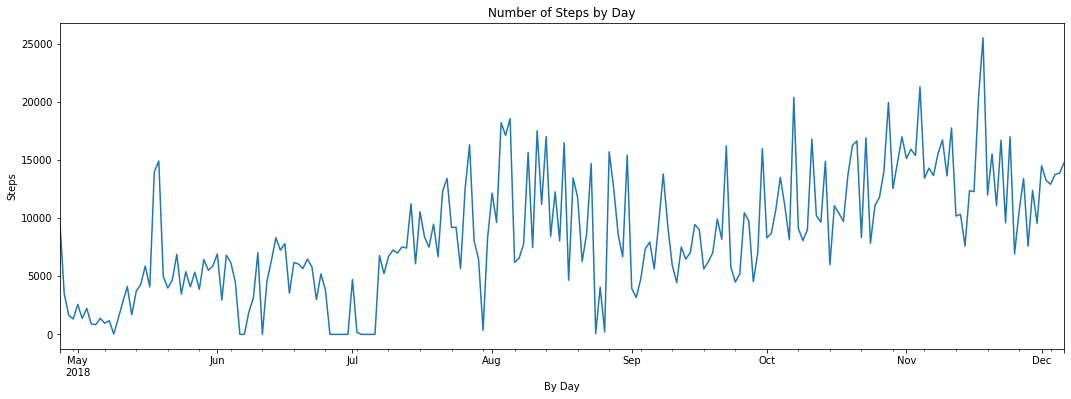

In [34]:
df['steps'].plot(figsize=(18,6))

plt.xlabel('By Day')
plt.ylabel('Steps')
plt.title('Number of Steps by Day')
plt.show()

## Drop Columns - Month, Weekday, and Floors for Modeling

In [35]:
df.drop(columns=['month', 'weekday', 'floors'], inplace=True)

## Fill Steps with NaN

- Use a lambda function to convert values of 0 in the steps column to Nans.

In [36]:
#df.steps = df.steps.apply(lambda x: np.nan if x == 0 else x)

### Takeaways:  Explore

- 

# Impute

- Decide on the best way to handle the missing step values in the data before going on to model using same methods to predict future values.

## Calculate Rolling Mean

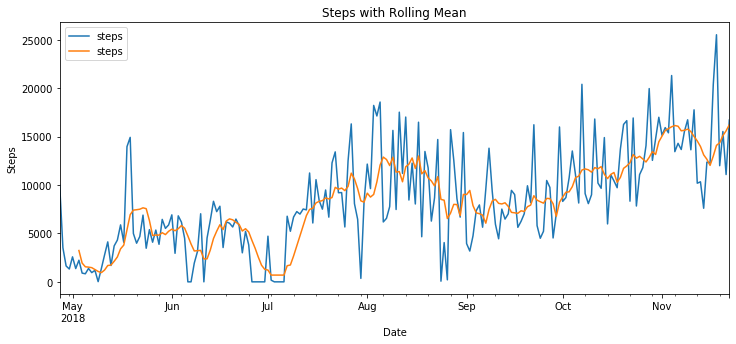

In [42]:
train['steps'].plot(figsize=(12,5))
train.rolling(window=7).mean()['steps'].plot()

plt.title('Steps with Rolling Mean')
plt.ylabel('Steps')
plt.legend()
plt.show()

In [39]:
df['steps_7_day_mean'] = df['steps'].rolling(window=7).mean()

In [40]:
df.head(5)

,calories_burned,steps,distance,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,steps_7_day_mean
Date,,,,,,,,,,,,,,,
2018-04-27,3649,9971,4.7,1158,219,46,17,1752,282,0.243523,2121.489362,0.365961,0.077281,0.317347,NaN
2018-04-28,3379,3521,1.7,702,155,22,11,1124,188,0.267806,2071.176471,0.959671,0.055638,0.207754,NaN
2018-04-29,2851,1639,0.8,891,122,0,0,602,122,0.136925,2048.750000,1.739475,0.042792,0.312522,NaN
2018-04-30,2825,1323,0.6,880,104,0,0,540,104,0.118182,2205.000000,2.135299,0.036814,0.311504,NaN
2018-05-01,3292,2581,1.2,919,167,13,2,1068,182,0.198041,2150.833333,1.275475,0.055286,0.279162,NaN


## Expanding Steps

In [41]:
df['steps_7_day_expand'] = df['steps'].expanding(min_periods=7).mean()

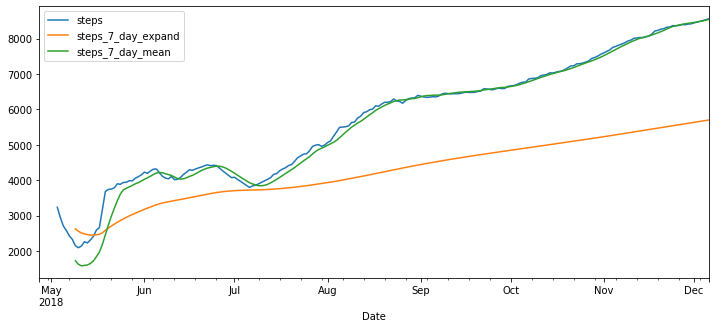

In [42]:
df[['steps', 'steps_7_day_expand', 'steps_7_day_mean']].expanding(min_periods=7).mean().plot(figsize=(12,5))

plt.show()

## Simple Moving Average (SMA)

- Create rolling_median Column

- Create a column called 'rolling_median' that contains the original values for 'steps' and imputed values of the median for steps where there are NaNs.

- This method can be skewed by more extreme historical values.

In [44]:
df = df.assign(rolling_median=df.steps.fillna(df.steps.rolling(14,min_periods=1,).median()))

In [46]:
df.head(10)

,calories_burned,steps,distance,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,steps_7_day_mean,steps_7_day_expand,rolling_median
Date,,,,,,,,,,,,,,,,,
2018-04-27,3649,9971,4.7,1158,219,46,17,1752,282,0.243523,2121.489362,0.365961,0.077281,0.317347,NaN,NaN,9971
2018-04-28,3379,3521,1.7,702,155,22,11,1124,188,0.267806,2071.176471,0.959671,0.055638,0.207754,NaN,NaN,3521
2018-04-29,2851,1639,0.8,891,122,0,0,602,122,0.136925,2048.750000,1.739475,0.042792,0.312522,NaN,NaN,1639
2018-04-30,2825,1323,0.6,880,104,0,0,540,104,0.118182,2205.000000,2.135299,0.036814,0.311504,NaN,NaN,1323
2018-05-01,3292,2581,1.2,919,167,13,2,1068,182,0.198041,2150.833333,1.275475,0.055286,0.279162,NaN,NaN,2581
2018-05-02,2660,1372,0.7,927,90,0,0,419,90,0.097087,1960.000000,1.938776,0.033835,0.348496,NaN,NaN,1372
2018-05-03,3121,2232,1.1,876,157,16,0,1006,173,0.197489,2029.090909,1.398297,0.055431,0.280679,3234.142857,3234.142857,2232
2018-05-04,2522,904,0.4,1012,61,0,0,269,61,0.060277,2260.000000,2.789823,0.024187,0.401269,1938.857143,2942.875000,904
2018-05-05,2551,833,0.4,969,68,0,0,326,68,0.070175,2082.500000,3.062425,0.026656,0.379851,1554.857143,2708.444444,833


## ETS Decomposition

- Error-Trend-Decomposition

- It looks like there is a lot of noise between August and September.

- It is easy to see the seasonality present.

- The trend is upward for the most part.

In [47]:
result = seasonal_decompose(df['rolling_median'], model='additive')

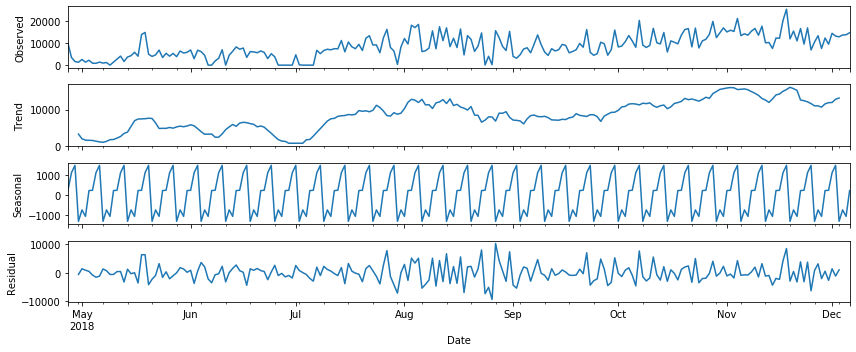

In [48]:
rcParams['figure.figsize']=(12,5)

result.plot()

plt.show()

## Exponentially Weighted Moving Average (EWMA)

- This allows the more recent data to be weighted more than the older data

- This might help reduce the noise in the data

- This could help us make better predictions and avoid problems with historical data issues.

In [49]:
df['EWMA_7'] = df['steps'].ewm(span=7).mean()

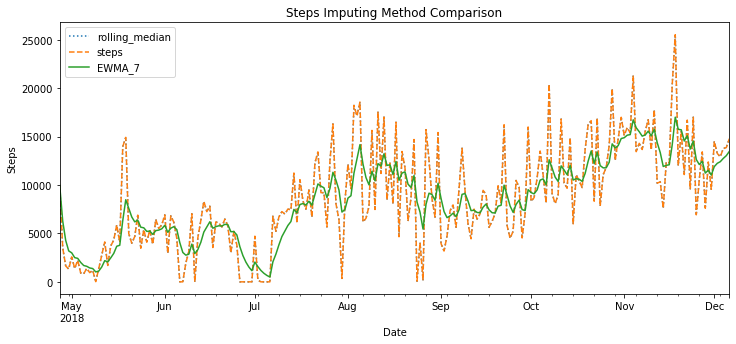

In [50]:
df[['rolling_median', 'steps', 'EWMA_7']].plot(style=[':', '--', '-'])

plt.title('Steps Imputing Method Comparison')
plt.ylabel('Steps')
plt.show()

## Comparison of All Impute Methods

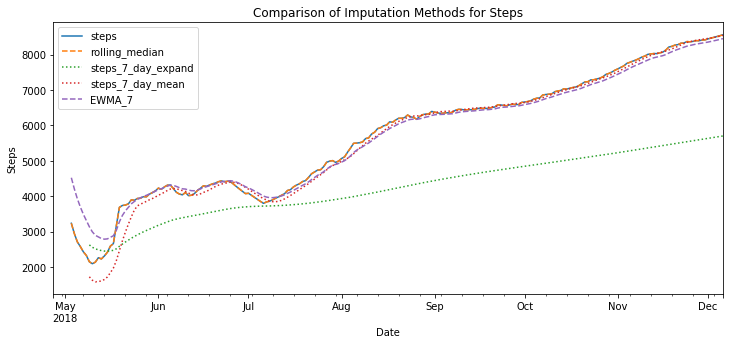

In [51]:
df[['steps', 'rolling_median', 'steps_7_day_expand', 'steps_7_day_mean', 'EWMA_7']].expanding(min_periods=7).mean().plot(style=['-', '--', ':', ':', '--'])

plt.ylabel('Steps')
plt.title('Comparison of Imputation Methods for Steps')
plt.show()

### Takeaways: Impute

- 

# Correlation with Steps

## Increase in Steps by Month

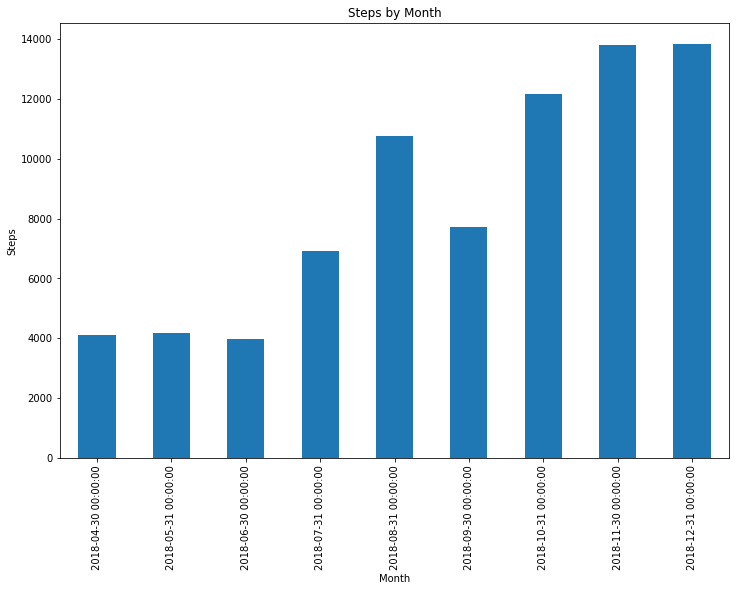

In [52]:
df['rolling_median'].resample('M').mean().plot.bar(figsize=(12,8))

plt.xlabel('Month')
plt.ylabel('Steps')
plt.title('Steps by Month')
plt.show()

## Steps and Calories Burned

- Sedentary mins looks negatively correlated with calories burned.

- Lightly active looks correlated with calories burned more than either very or fairly active.

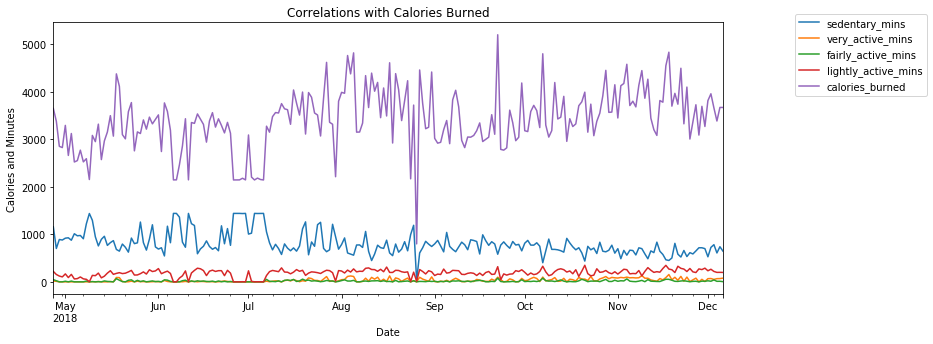

In [53]:
df[['sedentary_mins', 'very_active_mins', 'fairly_active_mins', 'lightly_active_mins', 'calories_burned']].plot()

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Correlations with Calories Burned')
plt.ylabel('Calories and Minutes')
plt.show()

In [54]:
df.isnull().sum()

calories_burned         0
steps                   0
distance                0
sedentary_mins          0
lightly_active_mins     0
fairly_active_mins      0
very_active_mins        0
activity_calories       0
active_total            0
ratio_act_sed           0
ratio_steps_distance    0
ratio_cal_steps         0
ratio_active_cal        0
ratio_sed_cal           0
steps_7_day_mean        6
steps_7_day_expand      6
rolling_median          0
EWMA_7                  0
dtype: int64

In [55]:
df.sort_values(by='rolling_median')

,calories_burned,steps,distance,sedentary_mins,lightly_active_mins,fairly_active_mins,very_active_mins,activity_calories,active_total,ratio_act_sed,ratio_steps_distance,ratio_cal_steps,ratio_active_cal,ratio_sed_cal,steps_7_day_mean,steps_7_day_expand,rolling_median,EWMA_7
Date,,,,,,,,,,,,,,,,,,
2018-06-29,2180,0,0.0,1437,3,0,0,39,3,0.002088,0.000000,0.000000,0.001376,0.659174,1716.428571,4136.046875,0,1531.934835
2018-06-11,2146,0,0.0,1440,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.671016,2367.714286,4015.304348,0,2921.403356
2018-06-28,2145,0,0.0,1440,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.671329,2545.714286,4201.698413,0,2042.579786
2018-07-06,2144,0,0.0,1440,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.671642,698.000000,3797.084507,0,497.757657
2018-07-05,2153,0,0.0,1439,1,0,0,10,1,0.000695,0.000000,0.000000,0.000464,0.668370,698.000000,3851.328571,0,663.676877
2018-07-04,2183,0,0.0,1438,2,0,0,42,2,0.001391,0.000000,0.000000,0.000916,0.658727,698.000000,3907.144928,0,884.902503
2018-07-03,2144,0,0.0,1440,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.671642,698.000000,3964.602941,0,1179.870005
2018-06-30,2145,0,0.0,1440,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.671329,1288.428571,4072.415385,0,1148.951123
2018-06-07,2146,0,0.0,1440,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.671016,3903.571429,4109.904762,0,3033.633465


## Steps and Trend

- using Hodrick-Prescott filter to find the cycle and trend of steps

- here you can see where the actual steps are above or below the trend

In [56]:
steps_cycle, steps_trend = hpfilter(df['rolling_median'], lamb=600)

In [57]:
df['steps_trend'] = steps_trend

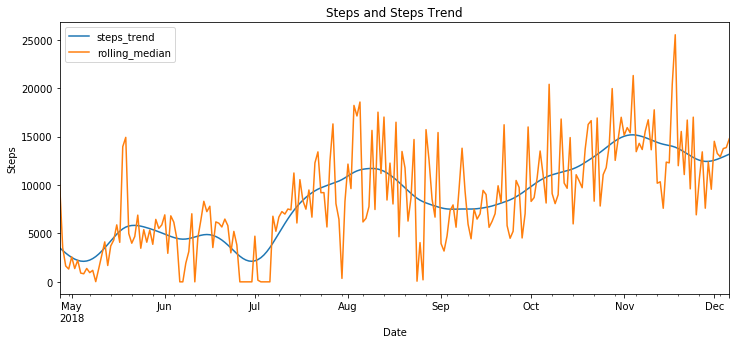

In [58]:
df[['steps_trend', 'rolling_median']].plot(figsize=(12,5))

plt.title('Steps and Steps Trend')
plt.ylabel('Steps')
plt.show()

## Percent Difference from First to Last Day

- There was a 48% increase in steps and distance from the first to the last day in the data set.

- There was a 358% increase in very_active_mins!

- There was a 77% increase in the ration_act_sed.

In [59]:
100 * (df.loc['2018-12-6'] - df.loc['2018-04-27'])/ df.loc['2018-04-27']

calories_burned           0.548095
steps                    48.169692
distance                 48.936170
sedentary_mins          -44.127807
lightly_active_mins      -9.589041
fairly_active_mins      -91.304348
very_active_mins        358.823529
activity_calories        11.986301
active_total             -0.709220
ratio_act_sed            77.710546
ratio_steps_distance     -0.514635
ratio_cal_steps         -32.139904
ratio_active_cal         -1.250462
ratio_sed_cal           -44.432370
steps_7_day_mean               NaN
steps_7_day_expand             NaN
rolling_median           48.169692
EWMA_7                   35.021946
steps_trend             275.911661
dtype: float64

### Correlation: Takeaways

- 

# Split Train and Test

- We want our test set to be about 20% of of our data set or at least as large as the future prediction we would like to make.

- We want our test set to be at least 2 weeks, since we want to forecast 2 weeks into the future past 2018-12-06.

- train (210, 14)

- test (14, 14)

In [46]:
train = df.loc[:'2018-11-22']
test = df.loc['2018-11-23':]

In [47]:
train.shape

(210, 14)

In [48]:
test.shape

(14, 14)

In [49]:
target_vars = ['steps']

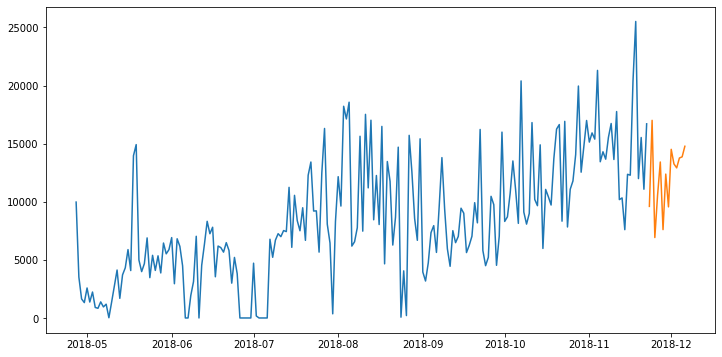

In [50]:
# validate train test split

for var in range(len(target_vars)):
    plt.figure(figsize=(12, 6))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

# Model

## Last Observed Value

- Get a baseline model using this simple forecasting method.

- Predict all future values to be the last observed value.

In [73]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
fitted_model = ExponentialSmoothing(train['rolling_median'],
                                   trend='mul', seasonal='mul',
                                   seasonal_periods=)

### Takeaways: Model

- 

# Forecast

# Final Takeaways

- Faith:


- Sean: